#### Import necessary modules for training a model

In [10]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
import h5py
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.preprocessing import sequence
import os
from collections import OrderedDict

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#### Load and preprocess the data

In [2]:
# parameters
max_features = 5000
maxlen = 400

print('Loading data...')
(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=max_features)
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)


/users/avanti/anaconda2/lib/python2.7/site-packages/keras/datasets/imdb.py:49: UserWarning: The `nb_words` argument in `load_data` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `load_data` '


#### Split the training set into a training and validation set

In [3]:
X_valid = X_train[20000:]
y_valid = y_train[20000:]
X_train = X_train[:20000]
y_train = y_train[:20000]
print('X_train shape:', X_train.shape)
print('X_valid shape:', X_valid.shape)
print('X_test shape:', X_test.shape)

X_train shape: (20000, 400)
X_valid shape: (5000, 400)
X_test shape: (25000, 400)


#### Train a model (the architecture ships with Keras)

In [45]:
# Building the model; architecture ships with Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding, SpatialDropout1D
from keras.layers import Convolution1D, GlobalMaxPooling1D

batch_size = 32
embedding_dims = 50
nb_filter = 250
filter_length = 3
hidden_dims = 250
epochs = 5

print('Build model...')
model = Sequential()
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))
model.add(SpatialDropout1D(0.2))
model.add(Conv1D(nb_filter=nb_filter,
                        filter_length=filter_length,
                        border_mode='valid',
                        activation='relu',
                        subsample_length=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(X_train, y_train,
          batch_size=batch_size,
          nb_epoch=epochs,
          validation_data=(X_valid, y_valid))
model.save("imdb_model.h5")

Build model...
Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 6s 282us/step - loss: 0.4316 - acc: 0.7810 - val_loss: 0.3222 - val_acc: 0.8582
Epoch 2/5
20000/20000 [==============================] - 5s 270us/step - loss: 0.2412 - acc: 0.9019 - val_loss: 0.2824 - val_acc: 0.8864
Epoch 3/5
20000/20000 [==============================] - 5s 270us/step - loss: 0.1558 - acc: 0.9428 - val_loss: 0.2851 - val_acc: 0.8918
Epoch 4/5
20000/20000 [==============================] - 5s 268us/step - loss: 0.1009 - acc: 0.9639 - val_loss: 0.3360 - val_acc: 0.8844
Epoch 5/5
20000/20000 [==============================] - 5s 270us/step - loss: 0.0594 - acc: 0.9802 - val_loss: 0.3868 - val_acc: 0.8910


/users/avanti/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:24: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", padding="valid", strides=1, filters=250, kernel_size=3)`


#### Compute model outputs (with and without test-time dropout) on the validation set

In [46]:
import abstention as ab

num_dropout_runs = 100 #the number of runs to use with test-time dropout
batch_size = 50
task_idx = 0 #output task to evaluate abstention metrics for

#preact_func returns the output prior to the final sigmoid nonlinearity, given the input
preact_func = ab.util.get_preact_func(model=model, task_idx=task_idx)

#Compute the output on the validation set pre-activation, both without test-time
#dropout and with test-time dropout enabled
print("On validation set")
valid_preacts, valid_dropout_preacts = ab.util.obtain_raw_data(
    preact_func=preact_func,
    data=X_valid,
    num_dropout_runs=num_dropout_runs,
    batch_size=batch_size)

#Do the same for the testing set
print("On testing set")
test_preacts, test_dropout_preacts = ab.util.obtain_raw_data(
    preact_func=preact_func, data=X_test, num_dropout_runs=num_dropout_runs, batch_size=batch_size)

On validation set
Computing deterministic activations
Computing nondeterministic activations
Done 10 runs
Done 20 runs
Done 30 runs
Done 40 runs
Done 50 runs
Done 60 runs
Done 70 runs
Done 80 runs
Done 90 runs
Done 100 runs
On testing set
Computing deterministic activations
Computing nondeterministic activations
Done 10 runs
Done 20 runs
Done 30 runs
Done 40 runs
Done 50 runs
Done 60 runs
Done 70 runs
Done 80 runs
Done 90 runs
Done 100 runs


#### Put model outputs through calibration

In [47]:
cb_method_name_to_factory = OrderedDict([
    #Expit is just the sigmoid; no calibration
    ("uncalibrated_posterior", ab.calibration.Expit()),
    ("ir_calibrated_posterior", ab.calibration.IsotonicRegression()),
    ("platt_calibrated_posterior", ab.calibration.PlattScaling()),
])

(cb_method_name_to_valid_posterior_prob,
 cb_method_name_to_test_posterior_prob,
 transform_name_to_valid_uncert,
 transform_name_to_test_uncert) = ab.util.obtain_posterior_probs_and_uncert_estimates(
                                    cb_method_name_to_factory=cb_method_name_to_factory,
                                    valid_labels=y_valid,
                                    valid_preacts=valid_preacts,
                                    valid_dropout_preacts=valid_dropout_preacts,
                                    test_preacts=test_preacts,
                                    test_dropout_preacts=test_dropout_preacts)

Platt scaling coef: 0.435289098439 ; intercept: 0.401095751806


`cb_method_name_to_valid_posterior_prob` and `cb_method_name_to_test_posterior_prob` have keys of:
- `uncalibrated_posterior` which has the uncalibrated (i.e.) the original probabilities
- `platt_calibrated_posterior` which has the calibrated probabilities using platt scaling
- `ir_calibrated_posterior` which has the calibrated probabilities using isotonic regression

In [48]:
print(cb_method_name_to_valid_posterior_prob.keys())
print(cb_method_name_to_test_posterior_prob.keys())

['uncalibrated_posterior', 'ir_calibrated_posterior', 'platt_calibrated_posterior']
['uncalibrated_posterior', 'ir_calibrated_posterior', 'platt_calibrated_posterior']


`transform_name_to_valid_uncert` and `transform_name_to_test_uncert` have keys of:
- `preactivation_uncertainty`, which has the population standard deviation computed on the output before the final nonlinearity
- `uncalibrated_posterior_uncertainty`, which has the population standard deviation computed on the uncertainties output after the final nonlinearity, but without any calibration applied
- `platt_calibrated_posterior_uncertainty`, which has the population standard deviation computed on the uncertainties output after the final nonlinearity and after calibration is applied using Platt scaling
- `ir_calibrated_posterior_uncertainty`, which has the population standard deviation computed on the uncertainties output after the final nonlinearity and after calibration is applied using Isotonic Regression

In [49]:
print(transform_name_to_valid_uncert.keys())
print(transform_name_to_test_uncert.keys())

['preactivation', 'uncalibrated_posterior', 'ir_calibrated_posterior', 'platt_calibrated_posterior']
['preactivation', 'uncalibrated_posterior', 'ir_calibrated_posterior', 'platt_calibrated_posterior']


Let's assess the quality of the calibration:

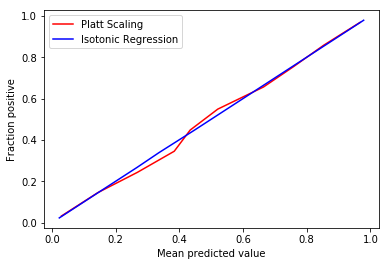

In [50]:
from matplotlib import pyplot as plt
import sklearn.calibration

platt_frac_pos, platt_mean_pred_val = sklearn.calibration.calibration_curve(
        y_true=y_valid,
        y_prob=cb_method_name_to_valid_posterior_prob['platt_calibrated_posterior'],
        normalize=False, n_bins=10)
ir_frac_pos, ir_mean_pred_val = sklearn.calibration.calibration_curve(
        y_true=y_valid,
        y_prob=cb_method_name_to_valid_posterior_prob['ir_calibrated_posterior'],
        normalize=False, n_bins=10)
handles = []
handles.append(plt.plot(platt_frac_pos, platt_mean_pred_val,color="red")[0])
handles.append(plt.plot(ir_frac_pos, ir_mean_pred_val, color="blue")[0])
plt.ylabel("Fraction positive")
plt.xlabel("Mean predicted value")
plt.legend(handles, ["Platt Scaling", "Isotonic Regression"])
plt.show()

It appears that Isotonic Regression is better, so we will use that below

In [51]:
import abstention
reload(abstention.abstention)
from abstention.abstention import AuPrcAbstentionEval, AuRocAbstentionEval
from abstention.abstention import (FixedThreshold, RandomAbstention,
                                   NegPosteriorDistanceFromThreshold,
                                   Uncertainty,
                                   MarginalDeltaAuRoc, MarginalDeltaAuPrc,
                                   RecursiveMarginalDeltaAuRoc,
                                   RecursiveMarginalDeltaAuPrc)
from collections import namedtuple

AbstentionFuncInfo = namedtuple('AbstentionFuncInfo',
                                ('method_name','factory', 'posterior', 'uncert'))

proportion_to_retain = 0.95
evaluation_functions = OrderedDict([('auPRC',AuPrcAbstentionEval(proportion_to_retain)),
                                    ('auROC',AuRocAbstentionEval(proportion_to_retain))])

num_positives = np.sum(y_train)+np.sum(y_valid)
imbalance = (len(y_train)+len(y_valid)-num_positives)/float(num_positives)

abstention_func_infos = [
         AbstentionFuncInfo(method_name='random', factory=RandomAbstention(),
                            posterior='ir_calibrated_posterior', uncert=None),
         AbstentionFuncInfo(method_name='calibrated_marginal_auroc',
                            factory=MarginalDeltaAuRoc(),
                            posterior='ir_calibrated_posterior', uncert=None),
         AbstentionFuncInfo(method_name='calibrated_marginal_auprc',
                            factory=MarginalDeltaAuPrc(),
                            posterior='ir_calibrated_posterior', uncert=None),
         AbstentionFuncInfo(method_name='recursive_calibrated_marginal_auroc',
                            factory=RecursiveMarginalDeltaAuRoc(proportion_to_retain),
                            posterior='ir_calibrated_posterior', uncert=None),
         AbstentionFuncInfo(method_name='recursive_calibrated_marginal_auprc',
                            factory=RecursiveMarginalDeltaAuPrc(proportion_to_retain),
                            posterior='ir_calibrated_posterior', uncert=None),
         AbstentionFuncInfo(method_name='uncalibrated_prob_distance_point_five',
                            factory=NegPosteriorDistanceFromThreshold(FixedThreshold(0.5)),
                            posterior='uncalibrated_posterior', uncert=None),
         AbstentionFuncInfo(method_name='calibrated_prob_distance_point_five',
                            factory=NegPosteriorDistanceFromThreshold(FixedThreshold(0.5)),
                            posterior='ir_calibrated_posterior', uncert=None),
         AbstentionFuncInfo(method_name='preactivation_uncertainty',
                            factory=Uncertainty(),
                            posterior='uncalibrated_posterior', uncert='preactivation'),
         AbstentionFuncInfo(method_name='uncalibrated_posterior_uncertainty',
                            factory=Uncertainty(),
                            posterior='uncalibrated_posterior', uncert='uncalibrated_posterior'),
         AbstentionFuncInfo(method_name='calibrated_posterior_uncertainty',
                            factory=Uncertainty(),
                            posterior='uncalibrated_posterior', uncert='ir_calibrated_posterior')]


In [52]:
metric_to_method_name_to_test_perfs = OrderedDict()
metric_to_method_name_to_valid_perfs = OrderedDict()
for metric_name in evaluation_functions:
    method_name_to_test_perfs = OrderedDict([
            (abstention_func.method_name, []) for abstention_func in abstention_func_infos])
    method_name_to_valid_perfs = OrderedDict([
            (abstention_func.method_name, []) for abstention_func in abstention_func_infos])
    metric_to_method_name_to_test_perfs[metric_name] = method_name_to_test_perfs
    metric_to_method_name_to_valid_perfs[metric_name] = method_name_to_valid_perfs

for abstention_func_info in abstention_func_infos:
    print("\nCalling method", abstention_func_info.method_name)
    factory = abstention_func_info.factory
    posterior_name = abstention_func_info.posterior
    uncert_name = abstention_func_info.uncert   

    valid_posterior = cb_method_name_to_valid_posterior_prob[posterior_name]
    test_posterior = cb_method_name_to_test_posterior_prob[posterior_name]
    valid_uncert = transform_name_to_valid_uncert[uncert_name] if uncert_name else None
    test_uncert = transform_name_to_test_uncert[uncert_name] if uncert_name else None
    
    abstention_func = factory(valid_labels=y_valid,
                              valid_posterior=valid_posterior,
                              valid_uncert=valid_uncert)
    test_abstention_scores = abstention_func(posterior_probs=test_posterior,
                                             uncertainties=test_uncert)
    valid_abstention_scores = abstention_func(posterior_probs=valid_posterior,
                                              uncertainties=valid_uncert)
    for evaluation_func_name, evaluation_func in evaluation_functions.items():
        valid_perf = evaluation_func(abstention_scores=valid_abstention_scores,
                                                            y_true=y_valid, y_score=valid_posterior)
        test_perf = evaluation_func(abstention_scores=test_abstention_scores,
                                                            y_true=y_test, y_score=test_posterior)
        metric_to_method_name_to_test_perfs[evaluation_func_name]\
                                      [abstention_func_info.method_name].append(test_perf)
        metric_to_method_name_to_valid_perfs[evaluation_func_name]\
                                      [abstention_func_info.method_name].append(valid_perf)


Calling method random

Calling method calibrated_marginal_auroc
valid est metric 0.958347435502
data est metric 0.954929000806
valid est metric 0.958347435502
data est metric 0.958330588286

Calling method calibrated_marginal_auprc
valid est metric 0.958759442373
data est metric 0.95543018847
valid est metric 0.958759442373
data est metric 0.958491368118

Calling method recursive_calibrated_marginal_auroc
Items recursively evicted: 0 of 1250
Items recursively evicted: 100 of 1250
Items recursively evicted: 200 of 1250
Items recursively evicted: 300 of 1250
Items recursively evicted: 400 of 1250
Items recursively evicted: 500 of 1250
Items recursively evicted: 600 of 1250
Items recursively evicted: 700 of 1250
Items recursively evicted: 800 of 1250
Items recursively evicted: 900 of 1250
Items recursively evicted: 1000 of 1250
Items recursively evicted: 1100 of 1250
Items recursively evicted: 1200 of 1250
Items recursively evicted: 0 of 250
Items recursively evicted: 100 of 250
Items re

In [53]:
from collections import defaultdict

print("\nBest auROC methods - test")
metric_to_auroc_test_score = defaultdict(lambda: 0)
metric_name_ranks = sorted(metric_to_method_name_to_test_perfs['auROC'].keys(),
                           key=lambda x: -metric_to_method_name_to_test_perfs['auROC'][x][0])
for idx, name in enumerate(metric_name_ranks):
        metric_to_auroc_test_score[name] += idx
print("AuROC ranks:")
print("\n".join(str(x)
                +", average auROC = "
                +str(np.mean(metric_to_method_name_to_test_perfs['auROC'][x[0]]))
                for x in sorted(metric_to_auroc_test_score.items(), key=lambda x: x[1])))

print("\nBest auPRC methods - test")
metric_to_auprc_test_score = defaultdict(lambda: 0)
metric_name_ranks = sorted(metric_to_method_name_to_test_perfs['auPRC'].keys(),
                           key=lambda x: -metric_to_method_name_to_test_perfs['auPRC'][x][0])
for idx, name in enumerate(metric_name_ranks):
        metric_to_auprc_test_score[name] += idx
print("AuPRC ranks:")
print("\n".join(str(x)
                +", average auPRC = "
                +str(np.mean(metric_to_method_name_to_test_perfs['auPRC'][x[0]]))
                for x in sorted(metric_to_auprc_test_score.items(), key=lambda x: x[1])))


Best auROC methods - test
AuROC ranks:
('uncalibrated_posterior_uncertainty', 0), average auROC = 0.959398326331
('calibrated_posterior_uncertainty', 1), average auROC = 0.959384161781
('uncalibrated_prob_distance_point_five', 2), average auROC = 0.959235900509
('calibrated_prob_distance_point_five', 3), average auROC = 0.958842739351
('recursive_calibrated_marginal_auroc', 4), average auROC = 0.95881899213
('calibrated_marginal_auroc', 5), average auROC = 0.958801794268
('calibrated_marginal_auprc', 6), average auROC = 0.958775029647
('recursive_calibrated_marginal_auprc', 7), average auROC = 0.958772843743
('random', 8), average auROC = 0.952369521501
('preactivation_uncertainty', 9), average auROC = 0.949492596417

Best auPRC methods - test
AuPRC ranks:
('calibrated_marginal_auroc', 0), average auPRC = 0.957059232443
('calibrated_marginal_auprc', 1), average auPRC = 0.956916274771
('calibrated_posterior_uncertainty', 2), average auPRC = 0.956878961856
('uncalibrated_posterior_uncer